In [1]:
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import torchvision.models as models

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp

from PIL import Image
from glob import glob

In [4]:
class ResLayer(nn.Module):
    def __init__(self,DEVICE):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(weights='IMAGENET1K_V1').to(DEVICE)
        self.num_ftrs = self.model.fc.out_features
        
        self.fc = nn.Sequential(
            #nn.BatchNorm1d(self.num_ftrs+self.n_mfcc),                
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    def forward(self, x):
        x = self.model(x)
        x  = self.fc(x)
        return x

def model_initialize(DEVICE):
    model = ResLayer(DEVICE)
    model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_1_baseline_seed_1004_norm_false_organics_speaker.pt"))
    #model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_2_baseline_seed_1004_norm_false_organics_speaker.pt"))
    #model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_3_baseline_seed_1004_norm_false_organics_speaker.pt"))
    #model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_4_baseline_seed_1004_norm_false_organics_speaker.pt"))
    #model.load_state_dict(torch.load("../model/Module/checkpoint/checkpoint_ros_fold_5_baseline_seed_1004_norm_false_organics_speaker.pt"))

    model.to(DEVICE).eval()
    return model

In [2]:
#음성 파일들
import os
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_initialize(device)

phras_file_path = "../../voice_data/organics/phrase_sig_dict.pickle"
phras_file_path_abs = os.path.abspath(phras_file_path)
with open(phras_file_path_abs,"rb") as fr:
    phrase_dict = pickle.load(fr)


IndentationError: unexpected indent (Temp/ipykernel_14008/2669485078.py, line 6)

---
### inference

In [3]:
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
import librosa

In [7]:

classes = ["healthy","pathology"]


class svd_dataset(Dataset):
    def __init__(self,
                data_path_list,
                y_label_list,
                classes,
                mfcc_params,
                mel_params,
                spectro_params,
                is_normalize,
                norm_mean_list,
                norm_std_list,
                augmentation=[],
                augment_params=dict(),
                transform=None,
                is_train=False,):

        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = y_label_list # label data
        self.classes=classes
        self.transform=transform

        # sweep params
        self.mel_params = mel_params
        self.spectro_params = spectro_params
        self.mfcc_params = mfcc_params
        #sr,n_mfcc,lifter, hop_length , win_length , n_mels , n_fft , f_max , batch_size

        self.is_train = is_train

        #noramlize 관련
        self.is_normalize = is_normalize
        if is_normalize:
            self.normalize=transforms.Normalize((norm_mean_list[1],norm_mean_list[1],norm_mean_list[1]),(norm_std_list[1],norm_std_list[1],norm_std_list[1]))
        else:
            self.normalize=None

        #augmentation들
        self.crop = None
        self.spec_augment = None
        self.augment_params = augment_params
        
        if "crop" in augmentation:
            self.crop = transforms.RandomApply([
                                                Cutout(self.augment_params['crop'][0],
                                                self.augment_params['crop'][1]),
                                                ],
                                                p = self.augment_params['crop'][2])
        if "spec_augment" in augmentation:
            self.spec_augment = transforms.RandomApply([
                                                    transforms.Compose([T.TimeMasking(time_mask_param=self.augment_params['spec_augment'][0]),
                                                                        T.FrequencyMasking(freq_mask_param=self.augment_params['spec_augment'][1]),],)
                                               ],
                                               p=self.augment_params['spec_augment'][2])

    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig = PhraseData.phrase_dict[ str(self.path_list[idx])+'-phrase.wav'] 
        #sig = preemphasis(sig)
        
        origin_length = sig.shape[0]
        
        if sig.shape[0] > self.mel_params["sr"]*2:
            origin_length = self.mel_params["sr"]*2
        
        origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
        
        length = self.mel_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        
        mel_feature = librosa.feature.melspectrogram(y=sig,
                                                    sr=self.mel_params["sr"],
                                                    # hyp param
                                                    n_mels = self.mel_params["n_mels"],
                                                    n_fft = self.mel_params["n_fft"],
                                                    win_length = self.mel_params["win_length"],
                                                    hop_length = self.mel_params["hop_length"],
                                                    fmax = self.mel_params["f_max"]
                                                    )
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max) 
        
        
        if self.transform:
            mel_feature = self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            MSF = torch.stack([mel_feature, mel_feature, mel_feature])# 3채널로 복사.
            MSF = MSF.squeeze(dim=1)    
            
            # global normalize
            if self.normalize:
                MSF = self.normalize(MSF)
            

            if self.is_train:
                #spec augment
                if self.crop:
                    MSF = self.crop(MSF)
                if self.spec_augment:
                    MSF = self.spec_augment(MSF)

        else:
            pass
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx])

In [8]:

def load_dataloader(X,Y_df,sublabel,BATCH_SIZE,multilabel):
    loader = torch.utils.data.DataLoader(dataset = 
                                            BowelDataset(X,
                                                        Y_df,
                                                        to_tensor = transforms.ToTensor(),
                                                        transform = torch.nn.Sequential(
                                                                transforms.Resize([512,512]),
                                                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                            ),
                                                        sublabel=sublabel, # color,residue,turbidity, label 중 어느것을 맞추려는지 입력.
                                                        multilabel=multilabel,
                                                        ),
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            num_workers=0
                                            ) # 순서가 암기되는것을 막기위해.

    return loader

In [9]:
def get_num(file_str):
    return int(file_str.split("\\")[-1].split(".")[0])

In [10]:
filename = list(map(get_num,images))

In [11]:
#첫번째 열 이름 바꿔주기
label_df = pd.read_csv('../bmc.csv')
column_names = list(label_df.columns)
column_names[0] = 'file_name'
label_df.columns = column_names

# # Y값 찾아오기
all_data = pd.merge(pd.DataFrame(filename, columns=['file_name']),label_df,left_on='file_name',right_on='file_name',how='inner')

In [12]:
test_loader = load_dataloader(images,all_data,"label",1,False)

In [13]:
criterion = nn.CrossEntropyLoss()
def test_evaluate(model,test_loader,criterion,DEVICE):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.

    file_list = []
    with torch.no_grad():
        for image,label,file_path in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            file_list += file_path
            
        return predictions,answers,test_loss,file_list

In [14]:
# 3m 30s
predictions,answers,_,file_list=test_evaluate(model,test_loader,criterion,device)

In [15]:
wrong_answer = []
for i in range(len(predictions)):
    if predictions[i].cpu().numpy()[0] != answers[i].cpu().numpy():
        wrong_answer.append(file_list[i])

In [16]:
to_csv = pd.DataFrame({"files":wrong_answer})
to_csv.to_csv("./wrong_segment.csv")
#to_csv.to_csv("./wrong.csv")

---
### GradCAM

In [17]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
import os

In [22]:
os.makedirs("./gradcam")

In [18]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

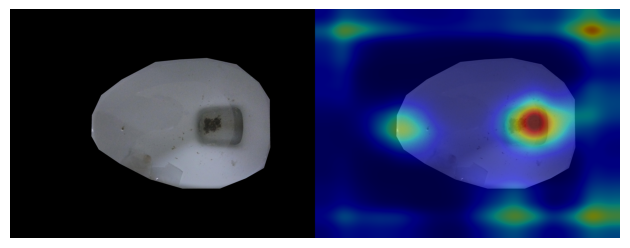

In [19]:
cam_extractor = SmoothGradCAMpp(model,target_layer="model.layer4")
# Get your input

for idx, path in enumerate(wrong_answer):
    img = read_image(path)
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (512, 512)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0).to(device))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    result = get_concat_h(to_pil_image(img), result)

    # Display it & save
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); #plt.show()
    plt.savefig('./gradcam_segment/%04d.png'%(idx))
    #plt.savefig('./gradcam/%04d.png'%(idx))
